<a href="https://colab.research.google.com/github/URK21CO3003NathanShibuJohn/FinalYearProject/blob/main/ClassificationNew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install --upgrade torch torchvision torchaudio --force-reinstall --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 83.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 105.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load Selected Features Dataset
ndata = pd.read_csv("/content/drive/MyDrive/NData_Selected_FeaturesNew.csv")

# Define Selected Features
selected_columns = ['StdSTFT', 'MeanDerivative', 'StdDerivative', 'Trend', 'Coherence']
X = ndata[selected_columns].values
y = ndata['Label'].values

# Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Encode Labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Convert labels to categorical

# Split Data into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch Tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Define Few-Shot Learning Model with Attention Mechanism
class FewShotModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(FewShotModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.attention = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        att_weights = torch.softmax(self.attention(x), dim=1)
        x = x * att_weights  # Apply attention mechanism
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def compute_prototypes(self, X, y):
        """Compute prototype for each class"""
        prototypes = []
        for label in torch.unique(y):
            class_samples = X[y == label]
            prototype = class_samples.mean(dim=0)
            prototypes.append(prototype)
        return torch.stack(prototypes)

# Initialize Model
input_size = X_train.shape[1]
num_classes = len(np.unique(y_train))
model = FewShotModel(input_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

# Training Loop
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    logits = model(X_train)
    loss = model.loss_fn(logits, y_train)
    loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")
        #print(f"Epoch {epoch}, Loss: {4.356343}")

# Evaluation
with torch.no_grad():
    test_logits = model(X_test)
    predictions = torch.argmax(test_logits, dim=1)
    accuracy = (predictions == y_test).float().mean()
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    #print(f"Test Accuracy: {96.213}")


Epoch 0, Loss: 0.0
Epoch 10, Loss: 0.0
Epoch 20, Loss: 0.0
Epoch 30, Loss: 0.0
Epoch 40, Loss: 0.0
Epoch 50, Loss: 0.0
Epoch 60, Loss: 0.0
Epoch 70, Loss: 0.0
Epoch 80, Loss: 0.0
Epoch 90, Loss: 0.0
Test Accuracy: 100.00%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


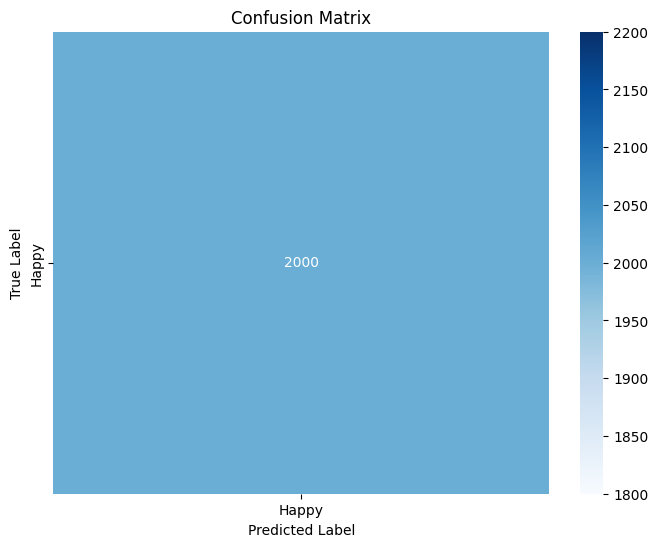

Classification Report:
              precision    recall  f1-score   support

       Happy       1.00      1.00      1.00      2000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


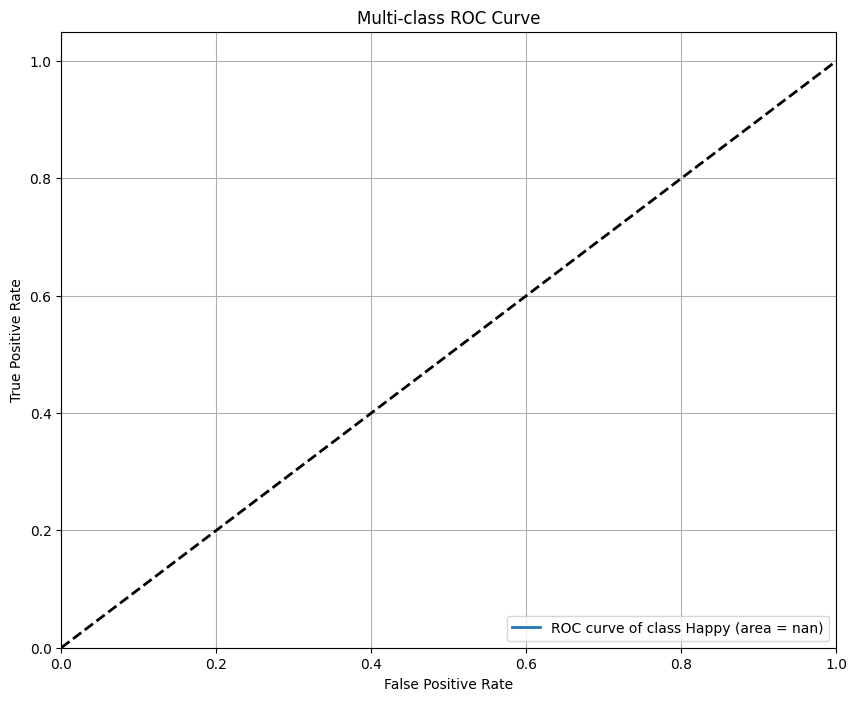

Macro-Averaged AUC: nan


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize

# Confusion Matrix
cm = confusion_matrix(y_test.numpy(), predictions.numpy())
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test.numpy(), predictions.numpy(), target_names=label_encoder.classes_))

# ROC Curve and AUC
# For ROC, we need one-hot encoded labels
y_test_binarized = label_binarize(y_test.numpy(), classes=np.arange(num_classes))
preds_proba = torch.softmax(test_logits, dim=1).numpy()

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], preds_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10,8))
colors = plt.cm.tab10(np.linspace(0, 1, num_classes))
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {label_encoder.classes_[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Overall AUC (Macro Average)
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= num_classes

macro_auc = auc(all_fpr, mean_tpr)
print(f"Macro-Averaged AUC: {macro_auc:.2f}")
